Code repurposed from Kaggle [https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-cryptocurrencies]

## import dependencies

In [1]:
import pandas as pd
import pandas_datareader as web
import numpy as np
from pathlib import Path
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

from yahoo_fin.stock_info import get_data

%matplotlib inline

## load and inspect data

In [2]:
crypto_currency = 'SOL1'
against_currency = 'USD'

start = dt.datetime(2014,1,1)
end = dt.datetime.now()

base_df = get_data(f'{crypto_currency}-{against_currency}', start, end, index_as_date = True, interval = '1d')
base_df

,open,high,low,close,adjclose,volume,ticker
2020-04-09,0.832005,1.313487,0.694187,0.951054,0.951054,87364276.0,SOL1-USD
2020-04-10,0.951054,1.049073,0.765020,0.776819,0.776819,43862444.0,SOL1-USD
2020-04-11,0.785448,0.956670,0.762426,0.882507,0.882507,38736897.0,SOL1-USD
2020-04-12,0.890760,0.891603,0.773976,0.777832,0.777832,18211285.0,SOL1-USD
2020-04-13,0.777832,0.796472,0.628169,0.661925,0.661925,16747614.0,SOL1-USD
...,...,...,...,...,...,...,...
2021-07-03,34.495117,35.502373,33.555737,34.310600,34.310600,303420520.0,SOL1-USD
2021-07-04,34.282551,34.461823,32.482693,32.984589,32.984589,313839322.0,SOL1-USD
2021-07-05,32.930305,34.978317,32.930305,34.269138,34.269138,365336040.0,SOL1-USD
2021-07-06,34.232807,38.011703,33.842030,36.591370,36.591370,519252659.0,SOL1-USD


In [3]:
base_df['spread'] = base_df.high - base_df.low
base_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 455 entries, 2020-04-09 to 2021-07-08
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      427 non-null    float64
 1   high      427 non-null    float64
 2   low       427 non-null    float64
 3   close     427 non-null    float64
 4   adjclose  427 non-null    float64
 5   volume    427 non-null    float64
 6   ticker    455 non-null    object 
 7   spread    427 non-null    float64
dtypes: float64(7), object(1)
memory usage: 32.0+ KB


## Plot the closing value of Solana over time

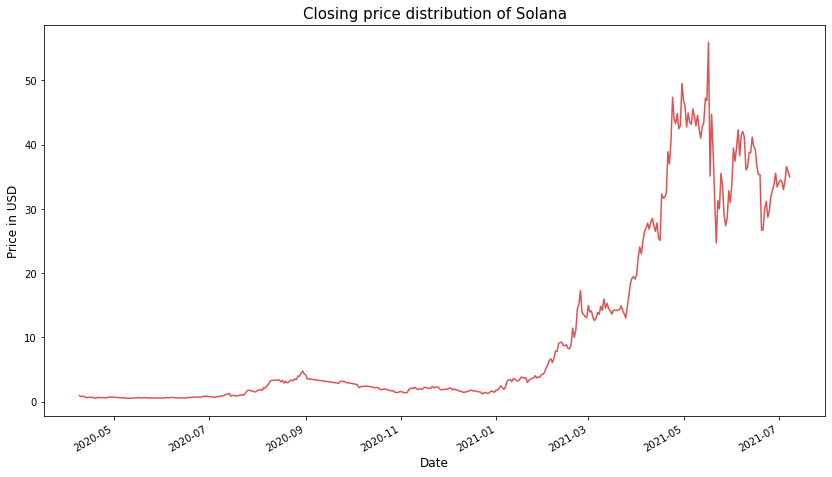

In [4]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14,8))

sns.lineplot(y = base_df.close.values, x=base_df.index.values, alpha=0.8, color=color[3])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title("Closing price distribution of Solana", fontsize=15)
plt.show()

Text(0.5, 1.0, 'Daily price spread of Solana')

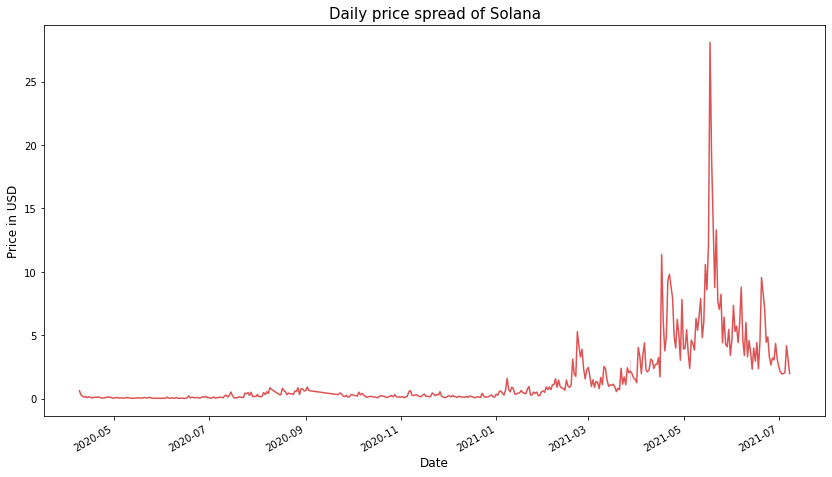

In [5]:
fig, ax = plt.subplots(figsize=(14,8))

sns.lineplot(y = base_df.spread.values, x=base_df.index.values, alpha=0.8, color=color[3])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title("Daily price spread of Solana", fontsize=15)

## Candlestick chart

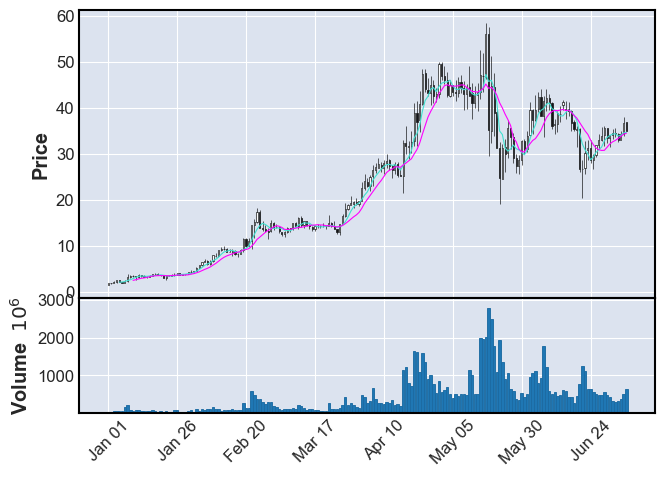

In [11]:
import matplotlib.ticker as mticker
import mplfinance as mpf

temp_base_df = base_df.copy(deep=False)

temp_base_df = temp_base_df.drop(['spread'], axis=1)
mpf.plot(temp_base_df.loc['2021-1-1':], type='candle', mav=(5,10), volume=True)

## Future Price Prediction

In [7]:
from fbprophet import Prophet

In [8]:
price_predict_df = base_df['close'].copy(deep=False).reset_index()
price_predict_df.columns = ["ds", "y"]
#price_predict_df = price_predict_df[price_predict_df['ds']>'2020-6-1']
price_predict_df

,ds,y
0,2020-04-09,0.951054
1,2020-04-10,0.776819
2,2020-04-11,0.882507
3,2020-04-12,0.777832
4,2020-04-13,0.661925
...,...,...
450,2021-07-03,34.310600
451,2021-07-04,32.984589
452,2021-07-05,34.269138
453,2021-07-06,36.591370


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
479,2021-08-03,35.038242,29.422396,40.351731
480,2021-08-04,35.169246,29.836870,40.382571
481,2021-08-05,34.624661,29.119273,40.458053
482,2021-08-06,34.764168,28.974160,40.552512
483,2021-08-07,35.016990,29.144139,40.842588


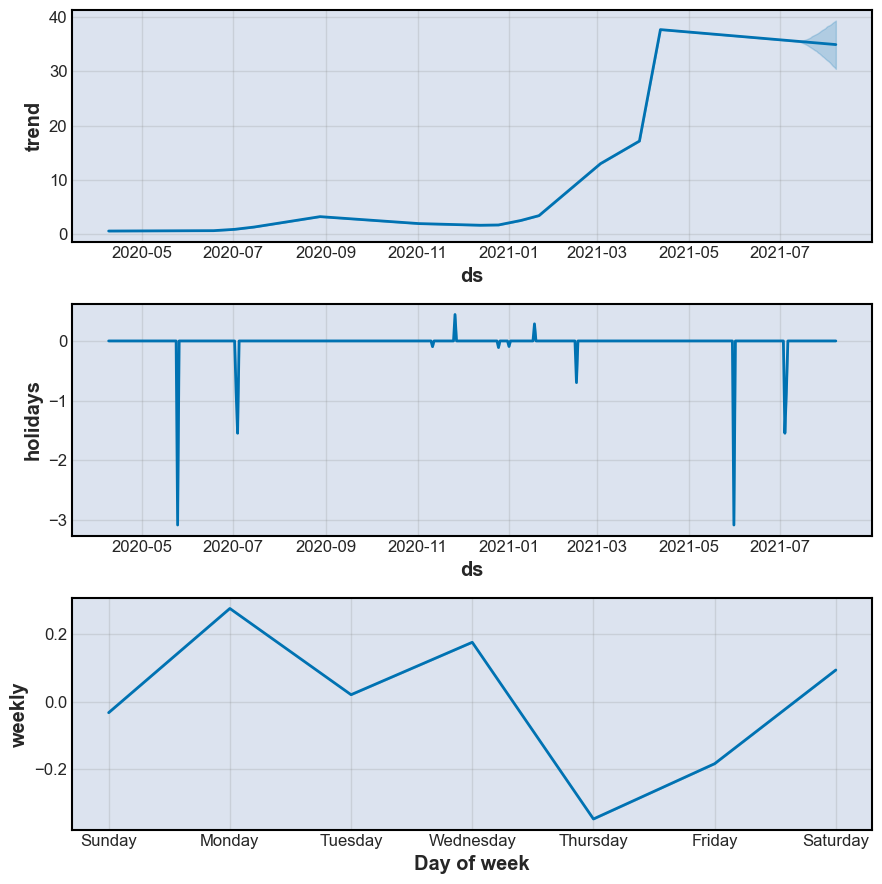

In [9]:
m = Prophet(changepoint_prior_scale=.7)
m.add_country_holidays(country_name='US')
#m.add_country_holidays(country_name='CN')
m.fit(price_predict_df);
m.train_holiday_names

future = m.make_future_dataframe(periods=30)

forecast = m.predict(future)
fig = m.plot_components(forecast)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

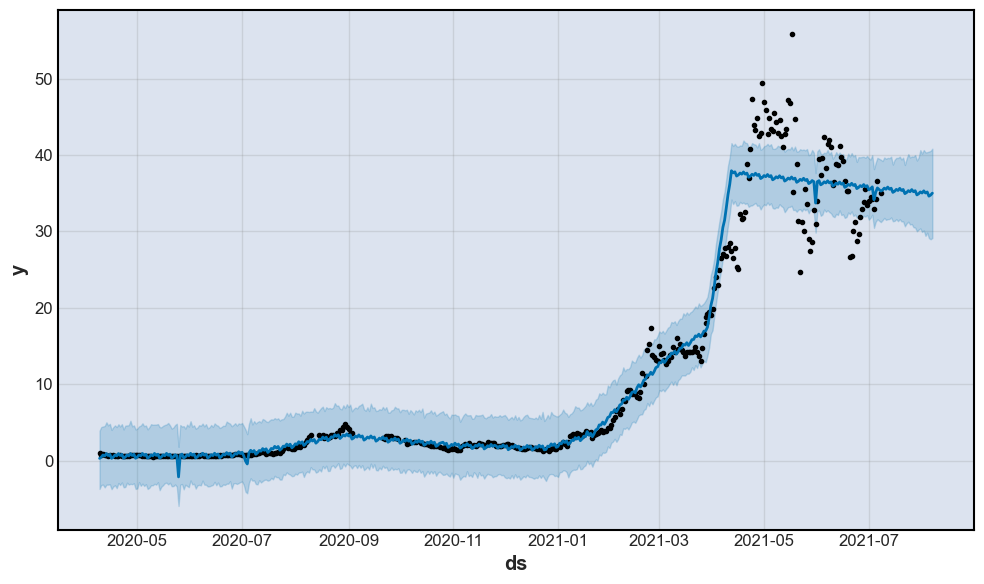

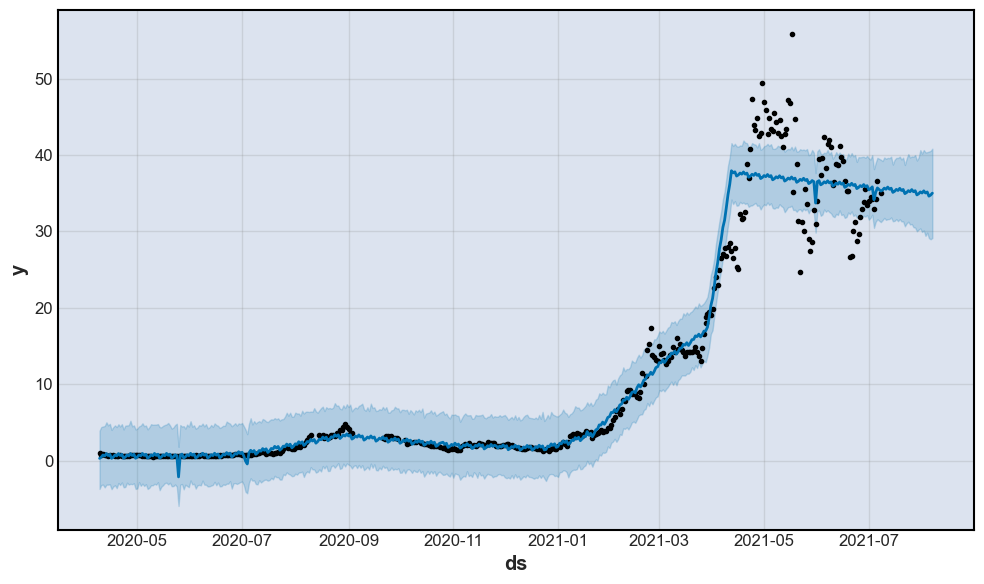

In [10]:
m.plot(forecast)